# Comparación de distintos parámetros en el algoritmo Lista de Clusters
En lo que sigue mostraremos el resultado de _clusterizar_ distintos conjuntos de datos usando el algoritmo de **Lista de Clusters**. Para ello modificamos los valores de los distintos parámetros del algoritmo:
- center_choise : {'p1', 'p2', 'p3', 'p4', 'p5'}, opcional, por defecto: 'p1'. Heurística de selección del centro:
        - 'p1': aleatoria
        - 'p2': el elemento más cercano al centro anterior en el conjunto restante
        - 'p3': el elemento más alejado al centro anterioren el conjunto restante
        - 'p4': el elemento que minimice la suma de las distancia a los centros previos
        - 'p5': el elemento que maximice la suma de las distancia a los centros previos
- fixed_radius : float, opcional, por defecto: None. La longitud de radio de cada cluster.
- fixed_size : int, opcional, por defecto: None. El número de elementos en cada cluster.
- distance_metric : {'euclidean', 'cityblock'}, opcional, por defecto: 'euclidean'. La medida de distancia a considerar.

Debemos notar que si se utiliza un valor para `fixed_size`, el algoritmo no considera el parámetro `fixed_radius`.

El objetivo aquí es encontrar aquellos parámetros que resulten en los mejores grupos.

## Importamos las librerías necesarias
Si vamos a comparar algoritmos de agrupamiento, necesitaremos algunas cosas; primero algunas bibliotecas para cargar y agrupar los datos, y en segundo lugar algunas herramientas de visualización para que podamos ver los resultados de la agrupación.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from list_of_clusters import ListOfClusters
import seaborn as sns

%matplotlib inline

np.random.seed(0)
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

## Generamos los distintos conjuntos de datos para comparar

In [2]:
def make_var_density_blobs(n_samples=750, centers=[[0,0]], cluster_std=[0.5]):
    samples_per_blob = n_samples // len(centers)
    blobs = [datasets.make_blobs(n_samples=samples_per_blob, centers=[c],
                                 cluster_std=cluster_std[i])[0]
             for i, c in enumerate(centers)]
    labels = [i * np.ones(samples_per_blob) for i in range(len(centers))]
    return np.vstack(blobs), np.hstack(labels)

# Elegimos el tamaño lo suficientemente grande como para ver la
# escalabilidad de los algoritmos, pero no demasiado grande para
# evitar tiempos de ejecución demasiado largos.
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.055)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.065)
blobs = datasets.make_blobs(n_samples=n_samples-200, random_state=8)
noisy_blobs = np.vstack((blobs[0], 25.0*np.random.rand(200, 2)-[10.0,10.0])),\
            np.hstack((blobs[1], -1*np.ones(200)))
varying_blobs = make_var_density_blobs(n_samples,
                                       centers=[[1, 1],
                                                [-1, -1],
                                                [1, -1]],
                                       cluster_std=[0.2, 0.35, 0.5])

# Aplicamos transformación a blobs
X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

easy_blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Definimos los parámetros para cada algoritmo dado cada conjunto de datos.
default_base = {'n_clusters': 3, 'fixed_size': 500, 'fixed_radius': 1.0}
clustering_datasets = [
    (noisy_circles, {'n_clusters': 2, 'fixed_size': 750, 'fixed_radius': 1.85}),
    (noisy_moons, {'n_clusters': 2, 'fixed_size': 750, 'fixed_radius': 1.75}),
    (noisy_blobs, {'fixed_radius': 1.7}),
    (varying_blobs, {'fixed_radius': 1.4}),
    (aniso, {'fixed_radius': 1.5}),
    (easy_blobs,{'fixed_radius': 0.96}),
    (no_structure, {})]

clustering_names = ['LC_1', 'LC_2', 'LC_3', 'LC_4', 'LC_5', 'LC_6', 'LC_7',
                    'LC_8', 'LC_9', 'LC_10']

## Comparamos los grupos generados usando la distancia euclideana

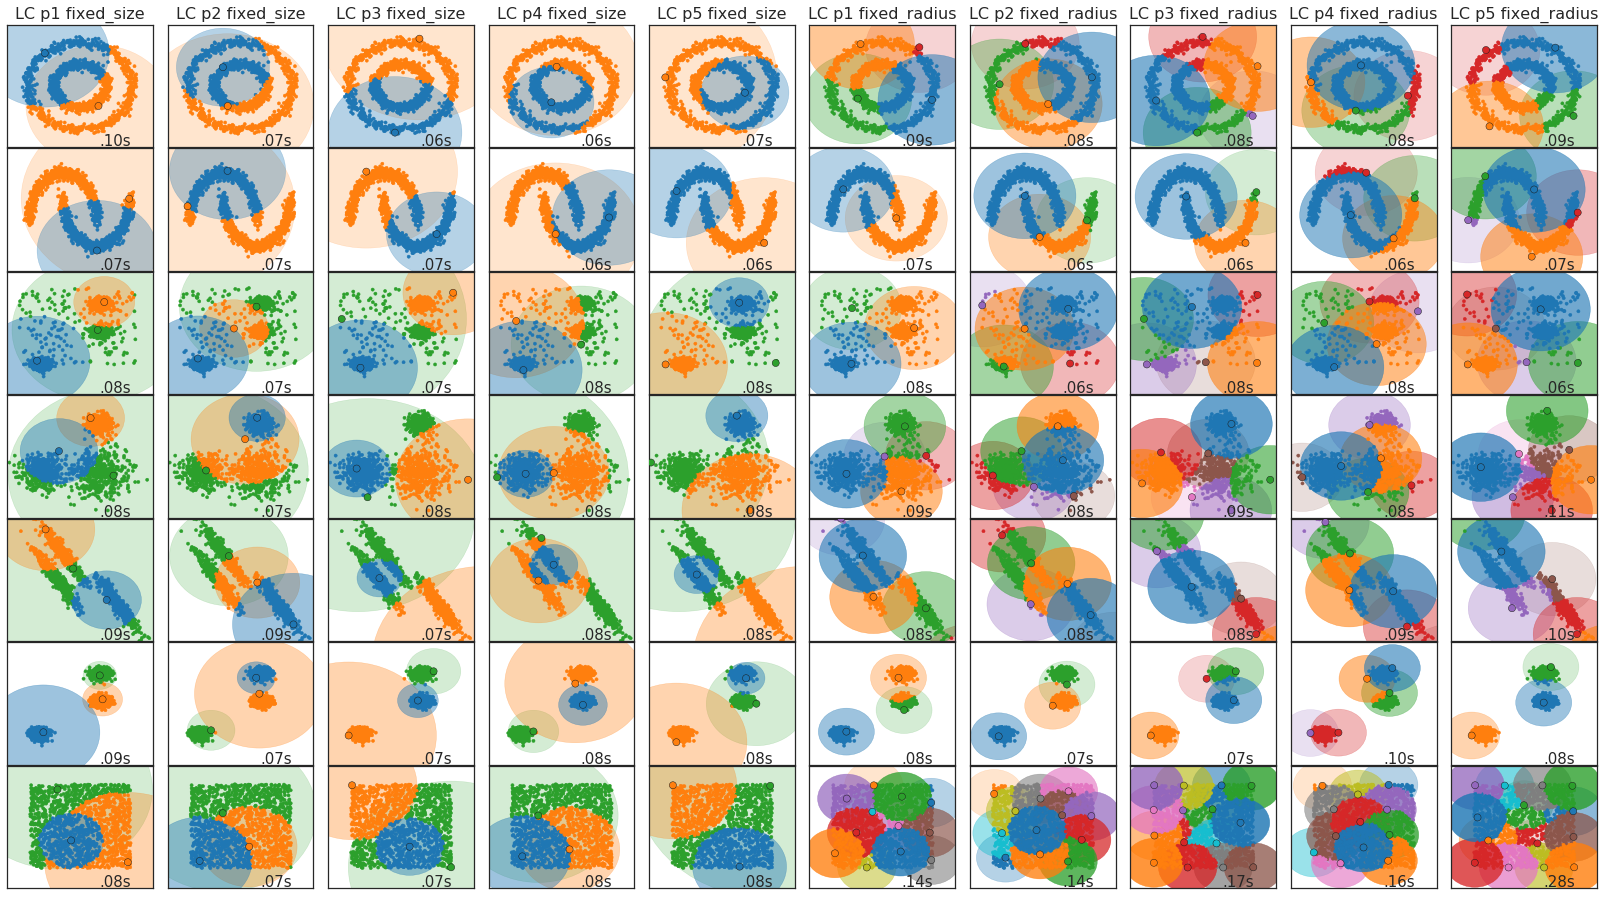

In [3]:
# https://matplotlib.org/examples/color/colormaps_reference.html
my_palette = 'tab10'

plt.figure(figsize=(len(clustering_names) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.1,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(clustering_datasets):
    # Actualizamos los parametros con los valores específicos para cada dataset
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    # Normalizamos el dataset para una selección de parámetros más sencilla.
    # Estandarizamos las características removiendo la media y
    # escalando a varianza unitaria.
    X = StandardScaler().fit_transform(X)

    # Creamos los estimadores para la tarea de clustering.
    lc1 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p1')
    lc2 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p2')
    lc3 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p3')
    lc4 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p4')
    lc5 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p5')
    lc6 = ListOfClusters(fixed_radius=params['fixed_radius'], center_choise='p1')
    lc7 = ListOfClusters(fixed_radius=params['fixed_radius'], center_choise='p2')
    lc8 = ListOfClusters(fixed_radius=params['fixed_radius'], center_choise='p3')
    lc9 = ListOfClusters(fixed_radius=params['fixed_radius'], center_choise='p4')
    lc10 = ListOfClusters(fixed_radius=params['fixed_radius'], center_choise='p5')
    
    clustering_algorithms = (
        ('LC p1 fixed_size', lc1),
        ('LC p2 fixed_size', lc2),
        ('LC p3 fixed_size', lc3),
        ('LC p4 fixed_size', lc4),
        ('LC p5 fixed_size', lc5),
        ('LC p1 fixed_radius', lc6),
        ('LC p2 fixed_radius', lc7),
        ('LC p3 fixed_radius', lc8),
        ('LC p4 fixed_radius', lc9),
        ('LC p5 fixed_radius', lc10)
    )
    
    for name, algorithm in clustering_algorithms:
        # Predecimos la pertenencia a clusters.
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # Graficamos
        ax = plt.subplot(len(clustering_datasets), len(clustering_algorithms),
                         plot_num)
        if i_dataset == 0:
            plt.title(name, size=16)
        
        palette = sns.color_palette(my_palette, np.unique(y_pred).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in y_pred]
        
        plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, zorder=2)

        if hasattr(algorithm, 'cluster_centers_'):
            # Invertimos el orden de los centros y sus colores para que
            # el primer centro obtenido quede en frente al graficar.
            centers = np.flip(algorithm.cluster_centers_, 0)
            center_colors = list(reversed(palette[:len(centers)]))
            plt.scatter(centers[:, 0], centers[:, 1], s=50, c=center_colors,\
                        edgecolors='k', zorder=3)

            if (hasattr(algorithm, 'cluster_radius_')):
                neg_alpha = 0.65

                # Invertimos al igual que con los centros y sus colores para
                # el caso de los radios y sus colores.
                radius = list(reversed(algorithm.cluster_radius_))
                cluster_colors = list(reversed(palette[:len(radius)]))

                for pos, r in enumerate(radius):
                    if algorithm.distance_metric == 'euclidean':
                        circle = plt.Circle((centers[pos][0],centers[pos][1]),
                                            r, color=cluster_colors[pos],
                                            alpha=0.85-neg_alpha, zorder=1)
                        ax.add_artist(circle)
                    elif algorithm.distance_metric == 'cityblock':
                        diagonal = 2*r
                        l = diagonal / (2**0.5)
                        rec_x = centers[pos][0]
                        rec_y = centers[pos][1] - r
                        rect = patches.Rectangle(xy=(rec_x, rec_y),
                                                 width=l, height=l,
                                                 zorder=1, angle=45,
                                                 color=cluster_colors[pos],
                                                 alpha=0.85-neg_alpha)
                        ax.add_patch(rect)
                    neg_alpha = neg_alpha * 0.80

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.85, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## Comparamos los grupos generados usando la distancia de manhattan

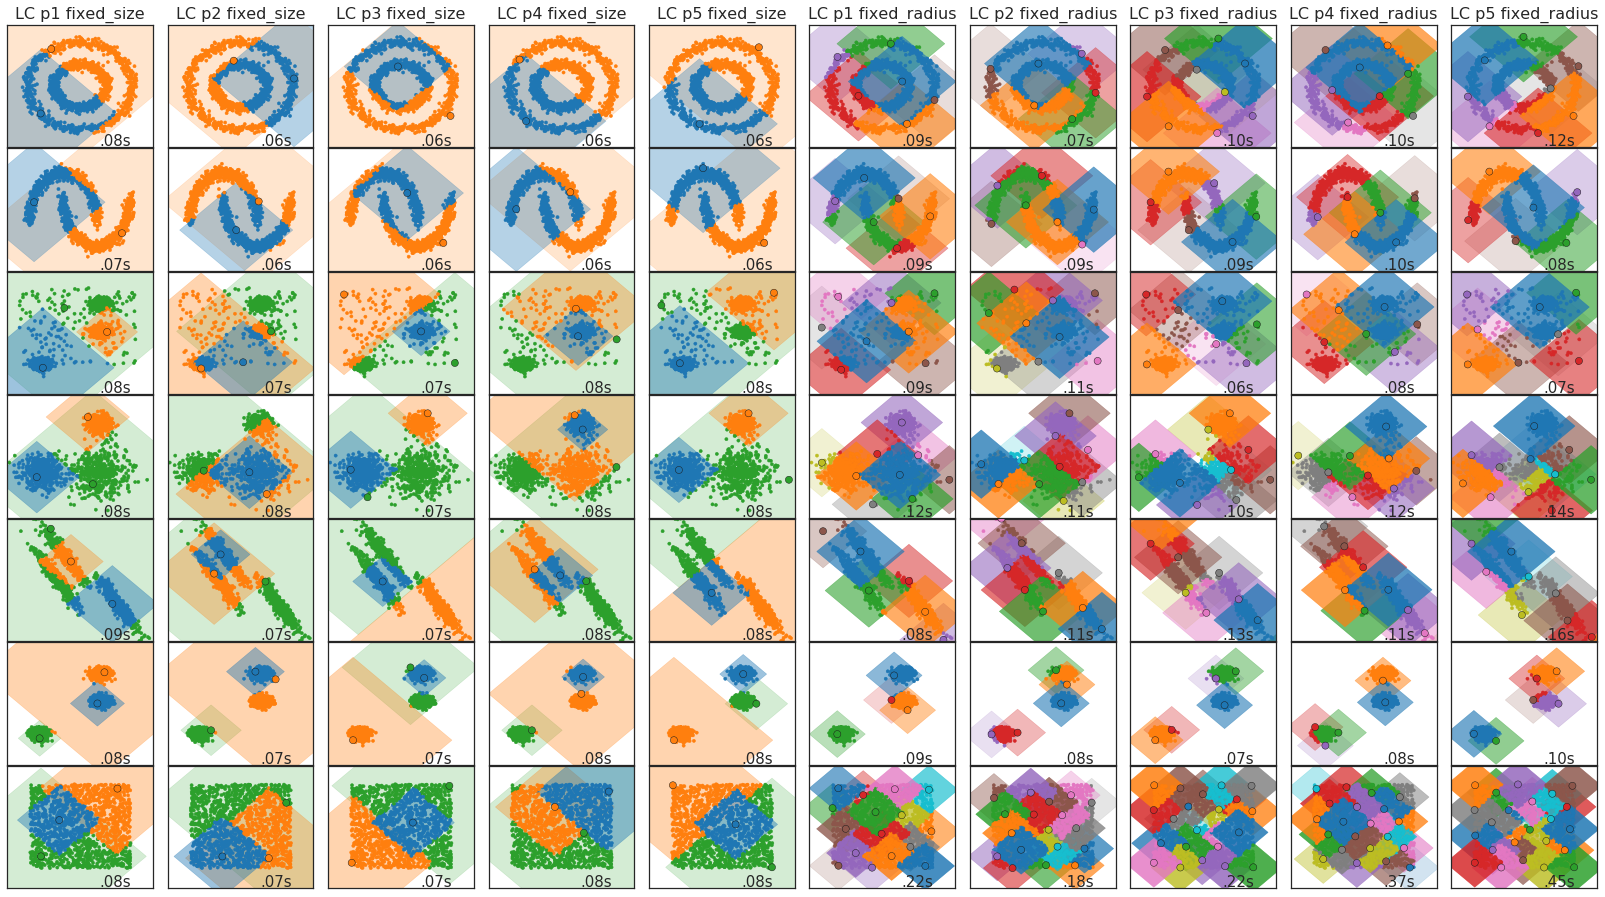

In [4]:
plt.figure(figsize=(len(clustering_names) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.1,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(clustering_datasets):
    # Actualizamos los parametros con los valores específicos para cada dataset
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    # Normalizamos el dataset para una selección de parámetros más sencilla.
    # Estandarizamos las características removiendo la media y
    # escalando a varianza unitaria.
    X = StandardScaler().fit_transform(X)

    # Creamos los estimadores para la tarea de clustering.
    lc1 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p1',
                         distance_metric='cityblock')
    lc2 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p2',
                         distance_metric='cityblock')
    lc3 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p3',
                         distance_metric='cityblock')
    lc4 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p4',
                         distance_metric='cityblock')
    lc5 = ListOfClusters(fixed_size=params['fixed_size'], center_choise='p5',
                         distance_metric='cityblock')
    lc6 = ListOfClusters(fixed_radius=params['fixed_radius'],
                         center_choise='p1', distance_metric='cityblock')
    lc7 = ListOfClusters(fixed_radius=params['fixed_radius'],
                         center_choise='p2', distance_metric='cityblock')
    lc8 = ListOfClusters(fixed_radius=params['fixed_radius'],
                         center_choise='p3', distance_metric='cityblock')
    lc9 = ListOfClusters(fixed_radius=params['fixed_radius'],
                         center_choise='p4', distance_metric='cityblock')
    lc10 = ListOfClusters(fixed_radius=params['fixed_radius'],
                          center_choise='p5', distance_metric='cityblock')
    
    clustering_algorithms = (
        ('LC p1 fixed_size', lc1),
        ('LC p2 fixed_size', lc2),
        ('LC p3 fixed_size', lc3),
        ('LC p4 fixed_size', lc4),
        ('LC p5 fixed_size', lc5),
        ('LC p1 fixed_radius', lc6),
        ('LC p2 fixed_radius', lc7),
        ('LC p3 fixed_radius', lc8),
        ('LC p4 fixed_radius', lc9),
        ('LC p5 fixed_radius', lc10)
    )
    
    for name, algorithm in clustering_algorithms:
        # Predecimos la pertenencia a clusters.
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # Graficamos
        ax = plt.subplot(len(clustering_datasets), len(clustering_algorithms),
                         plot_num)
        if i_dataset == 0:
            plt.title(name, size=16)
        
        palette = sns.color_palette(my_palette, np.unique(y_pred).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in y_pred]
        
        plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, zorder=2)

        if hasattr(algorithm, 'cluster_centers_'):
            # Invertimos el orden de los centros y sus colores para que
            # el primer centro obtenido quede en frente al graficar.
            centers = np.flip(algorithm.cluster_centers_, 0)
            center_colors = list(reversed(palette[:len(centers)]))
            plt.scatter(centers[:, 0], centers[:, 1], s=50, c=center_colors,\
                        edgecolors='k', zorder=3)

            if (hasattr(algorithm, 'cluster_radius_')):
                neg_alpha = 0.65

                # Invertimos al igual que con los centros y sus colores para
                # el caso de los radios y sus colores.
                radius = list(reversed(algorithm.cluster_radius_))
                cluster_colors = list(reversed(palette[:len(radius)]))

                for pos, r in enumerate(radius):
                    if algorithm.distance_metric == 'euclidean':
                        circle = plt.Circle((centers[pos][0],centers[pos][1]),
                                            r, color=cluster_colors[pos],
                                            alpha=0.85-neg_alpha, zorder=1)
                        ax.add_artist(circle)
                    elif algorithm.distance_metric == 'cityblock':
                        diagonal = 2*r
                        l = diagonal / (2**0.5)
                        rec_x = centers[pos][0]
                        rec_y = centers[pos][1] - r
                        rect = patches.Rectangle(xy=(rec_x, rec_y),
                                                 width=l, height=l,
                                                 zorder=1, angle=45,
                                                 color=cluster_colors[pos],
                                                 alpha=0.85-neg_alpha)
                        ax.add_patch(rect)
                    neg_alpha = neg_alpha * 0.80

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.85, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()